<a href="https://colab.research.google.com/github/marudesousa/DataScienceIII/blob/main/(MDeSousa)_E_commerce_Clothing_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Abstracto**

Las reseñas de clientes en e-commerce de ropa son una fuente clave para entender la satisfacción, expectativas e intereses de las compradoras. Analizar estos textos nos permite extraer insights accionables que guíen decisiones de producto, marketing y atención al cliente.

Teniendo esto en cuenta, un equipo podría usarlo como guia para saber que tipo de producto seguir comprando o dejar de comprar para su inventario e incluso que promociones serian las mas exitosas y rentables para su negocio.


# **Audiencia**

Este proyecto se desarrolló con fines educativos. Hipotéticamente, un análisis como este podría ser de gran utilidad para equipos de UX, BI, Marketing y Product Owners.


# **Objetivo**

Hacer un análisis de sentimiento sobre las reseñas de “Womens Clothing E-Commerce Reviews” para detectar patrones de opinión positiva/negativa y asi entrenar un modelo supervisado capaz de predecir el sentimiento de nuevas reseñas.


# **Descripción del dataset**

El archivo incluye 10 columnas:



*   Clothing ID: Identificador del artículo de ropa.
*   Age: Edad de la compradora.

*   Title: Título breve de la reseña.

*   Review Text: Texto completo de la reseña.

*   Rating: Calificación numérica (1–5).
*   Recommended IND: Indicador binario de recomendación (0=no, 1=sí).

*   Positive Feedback Count: Cantidad de votos “útil” que recibió la reseña.

*   Division Name: División del catálogo (por ej. “General”).


*   Department Name: Departamento (por ej. “Tops”).

*   Class Name: Categoría específica (por ej. “Blouses”).









# Librerias y Archivo

In [27]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización básica
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# NLP básico
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Modelado y vectorización
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB


# Métricas y evaluación
from scipy.sparse import vstack
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# Descargas NLTK necesarias
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# URL RAW del CSV en GitHub
github_url = 'https://raw.githubusercontent.com/marudesousa/DataScienceIII/refs/heads/main/Womens%20Clothing%20E-Commerce%20Reviews.csv'

df = pd.read_csv(github_url)

# Ver las primeras filas
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses


# Análisis Exploratorio y Limpieza Básica

In [3]:
print(df.isnull().sum())

Clothing ID                   0
Age                           0
Title                      3758
Review Text                 833
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64


In [4]:
print("Distribución de Rating:")
print(df["Rating"].value_counts().sort_index())

Distribución de Rating:
Rating
1      842
2     1565
3     2871
4     5007
5    12971
Name: count, dtype: int64


In [5]:
# Buscar edades que puedan ser error
invalid_ages = df[(df['Age'] < 10) | (df['Age'] > 100)]
invalid_ages[['Clothing ID', 'Age', 'Review Text']]

,Clothing ID,Age,Review Text


In [6]:
#Chequear si hay duplicados
print(df.duplicated().sum())

20


Después de un corto análisis vemos que las edades tienen sentido, tenemos una muestra de todos los ratings posibles (del 1 al 5) aunque la mayoria son positivos (5).

Algunas cosas para limpiar son los nulos, duplicados y columnas innecesarias. Decidí deshacerme de 'Department Name' por ser redundante con otras columnas, de 'Title' de la reseña porque tiene muchos nulos y no será el texto que analicemos.

También eliminaré duplicados y nulos en general, ya que en este caso no son una gran parte de la muestra y no tendria mucho sentido reemplazarlos con algo más, en especial las reseñas vacias.

In [7]:
# Remover columnas
columns_to_drop = ["Title", "Department Name"]
df = df.drop(columns=columns_to_drop, axis=1)

# Eliminar nulos
df = df.dropna()

# Eliminar duplicados
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows to remove: {duplicate_count}")
df = df.drop_duplicates()

# Preview de dataset limpio
print(f"Dataset limpio: {df.shape}")
df.head()

Number of duplicate rows to remove: 1
Dataset limpio: (22409, 8)


,Clothing ID,Age,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Class Name
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimates
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses
2,1077,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Pants
4,1080,49,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses


<ipython-input-10-51a5f1321af1>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


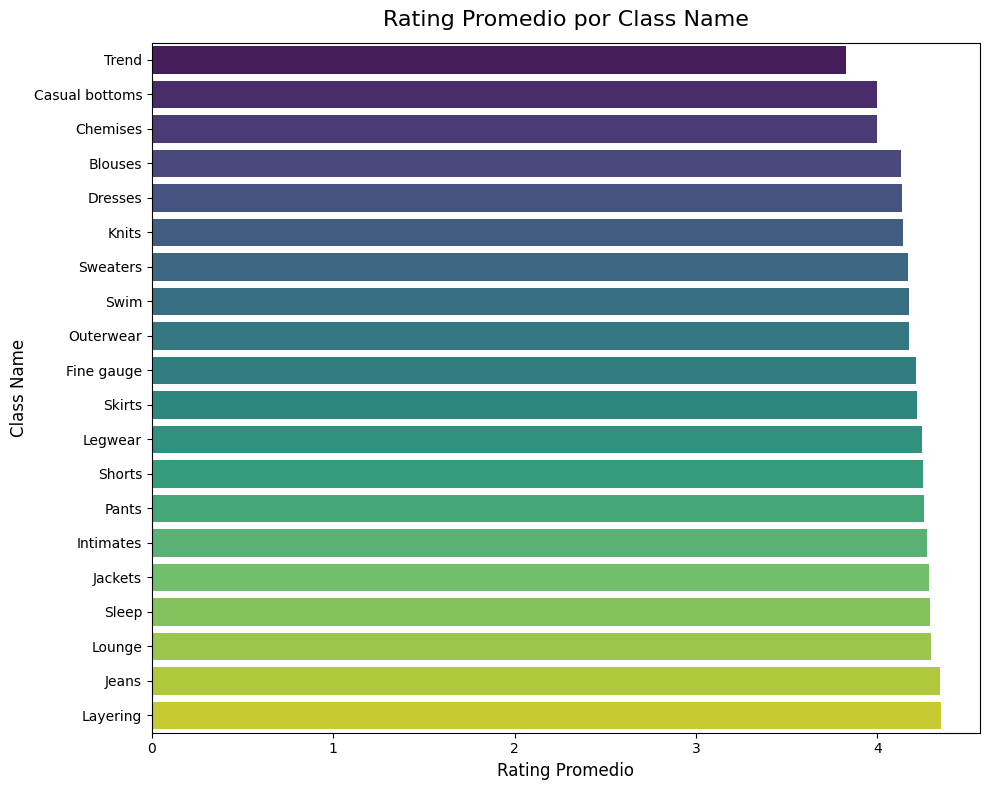

In [10]:
# Rating promedio para cada categoría (Class Name)
rating_by_class = (
    df.groupby("Class Name")["Rating"]
      .mean()
      .sort_values()
)

# Grafico
plt.figure(figsize=(10, 8))
sns.barplot(
    x=rating_by_class.values,
    y=rating_by_class.index,
    palette="viridis"
)
plt.title("Rating Promedio por Class Name", fontsize=16, pad=12)
plt.xlabel("Rating Promedio", fontsize=12)
plt.ylabel("Class Name", fontsize=12)
plt.tight_layout()
plt.show()

<ipython-input-11-12fd1cf8bdb9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Rating", data=df, palette="viridis")


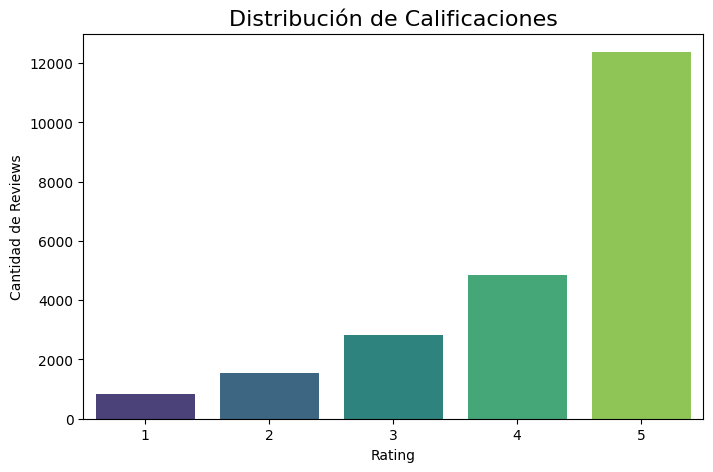

In [11]:
#Distribución de ratings
plt.figure(figsize=(8, 5))
sns.countplot(x="Rating", data=df, palette="viridis")
plt.title("Distribución de Calificaciones", fontsize=16)
plt.xlabel("Rating")
plt.ylabel("Cantidad de Reviews")
plt.show()

Ahora para continuar trabajando con el texto veremos una Word Cloud de las reseñas

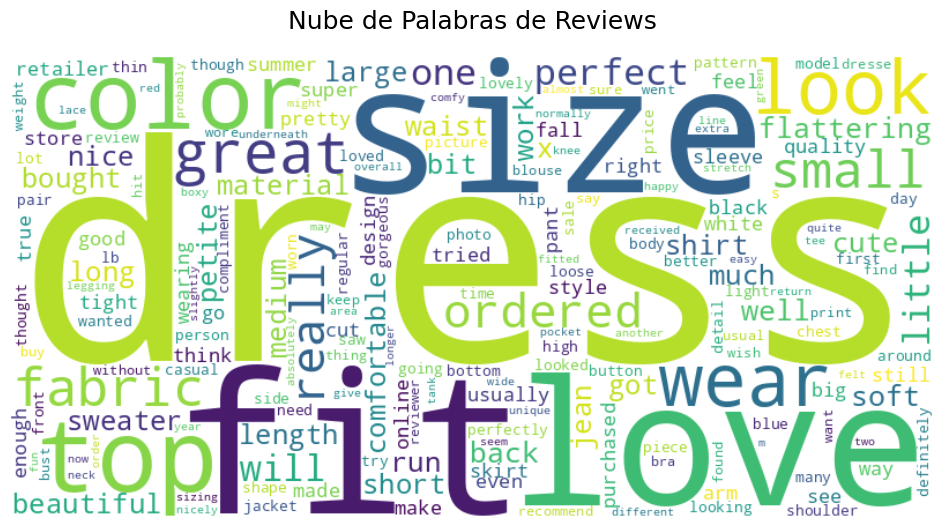

In [12]:
# Concatenar todos los textos de reseña en un solo string
all_text = " ".join(df["Review Text"].tolist())

# Definir stopwords
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

# Generar la Word Cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=stopwords,
    collocations=False
).generate(all_text)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de Palabras de Reviews", fontsize=18, pad=20)
plt.show()

## Preprocesamiento de Texto

Voy a crear una nueva columna de sentimiento para ser mas claros con el rating

In [13]:
# Creación de la columna 'Sentiment'
def map_sentiment(rating):
    # Ratings 1–2: negativo, 3: neutral, 4–5: positivo
    if rating <= 2:
        return 'negativo'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positivo'

df['Sentiment'] = df['Rating'].apply(map_sentiment)

df.head()

,Clothing ID,Age,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Class Name,Sentiment
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimates,positivo
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,positivo
2,1077,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,neutral
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Pants,positivo
4,1080,49,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,negativo


Y acá hacemos todos los pasos de tokenización, limpieza avanzada y lemmatizacion

In [14]:

# Recursos NLTK necesarios
nltk.download('punkt')
nltk.download('punkt_tab')    # Para cubrir un LookupError raro que me salió
nltk.download('stopwords')
nltk.download('wordnet')

# Tokenizador y stopwords sin colisiones
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer

# Instanciar lematizador y stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(nltk_stopwords.words('english'))

def clean_text(text):
    """
    1. Pasa a minúsculas
    2. Elimina URLs y caracteres no alfabéticos
    3. Tokeniza
    4. Filtra stopwords y tokens cortos (<3 caracteres)
    5. Lemmatiza
    6. Reconstruye el texto limpio
    """
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zñáéíóúü\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

# Limpieza
df['Cleaned_Review'] = df['Review Text'].apply(clean_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


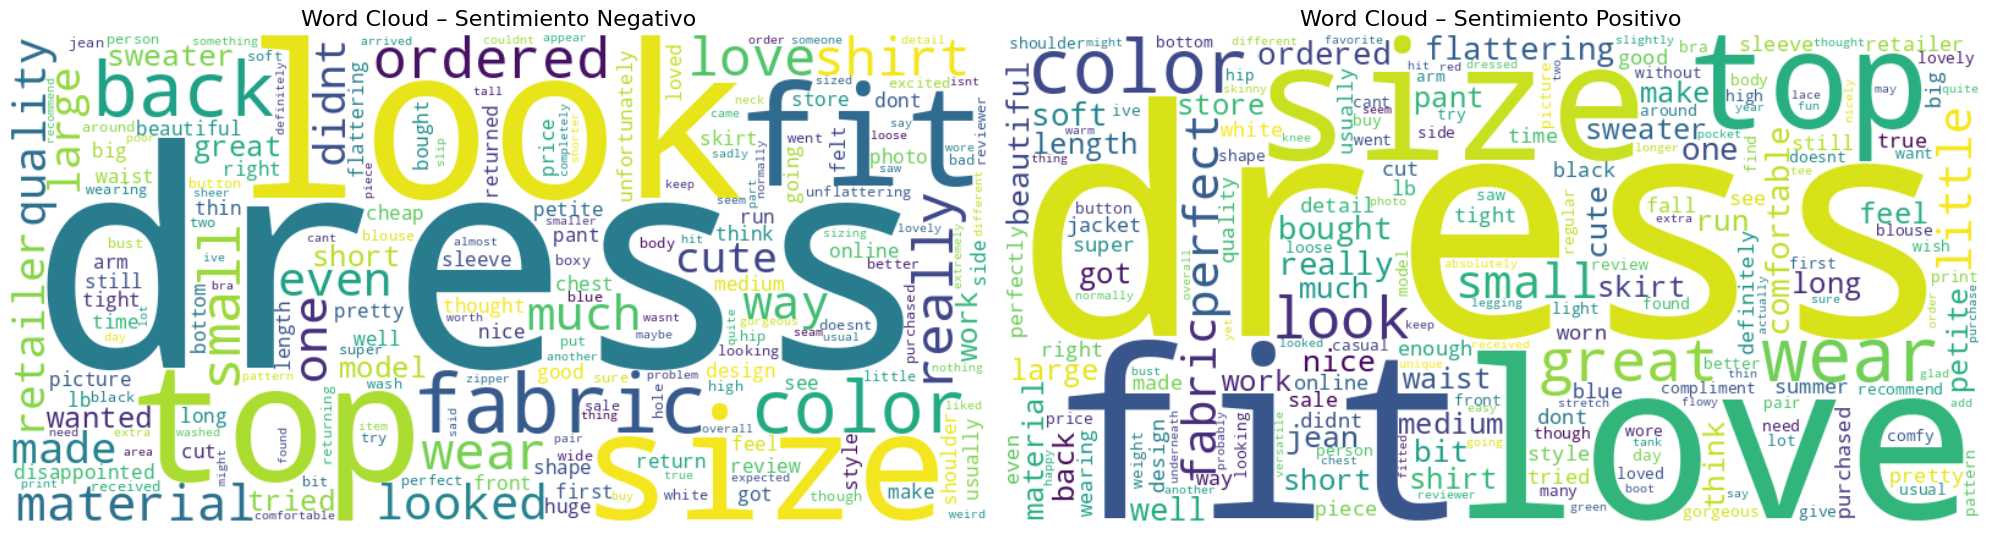

In [15]:
# Textos por sentimiento
neg_text = " ".join(df.loc[df['Sentiment'] == 'negativo', 'Cleaned_Review'])
pos_text = " ".join(df.loc[df['Sentiment'] == 'positivo', 'Cleaned_Review'])

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Word Cloud – Sentimiento Negativo
wc_neg = WordCloud(
    width=800, height=400,
    background_color='white',
    stopwords=STOPWORDS,
    collocations=False
).generate(neg_text)
axes[0].imshow(wc_neg, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud – Sentimiento Negativo', fontsize=16)

# Word Cloud – Sentimiento Positivo
wc_pos = WordCloud(
    width=800, height=400,
    background_color='white',
    stopwords=STOPWORDS,
    collocations=False
).generate(pos_text)
axes[1].imshow(wc_pos, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Word Cloud – Sentimiento Positivo', fontsize=16)

plt.tight_layout()
plt.show()

## Feature Selection

In [17]:
# Encode de la variable objetivo que creamos

le = LabelEncoder()
y_encoded = le.fit_transform(df['Sentiment'])
# le.classes_ → ['negativo', 'neutral', 'positivo']
print("Clases originales y su distribución:", Counter(y_encoded))


vectorizer = TfidfVectorizer(
    max_features=5000,    # top 5k features
    ngram_range=(1, 2)    # unigramas + bigramas
)

# Ajustamos el modelo y transformamos el texto limpio
X = vectorizer.fit_transform(df['Cleaned_Review'])



Clases originales y su distribución: Counter({np.int64(2): 17216, np.int64(1): 2823, np.int64(0): 2370})


**Debido a que el dataset tiene en su mayoria opiniones positivas, hice un under-sampling para evitar problemas por el desbalance**

In [19]:
# Instanciar el under-sampler
rus = RandomUnderSampler(random_state=42)

# Aplicar resampling sobre X (TF-IDF) y y_encoded
X_res, y_res = rus.fit_resample(X, y_encoded)

# Verificar nueva distribución
print("Distribución tras under-sampling:", Counter(y_res))


Distribución tras under-sampling: Counter({np.int64(0): 2370, np.int64(1): 2370, np.int64(2): 2370})


## Modelado

In [20]:
# Separar el conjunto de prueba (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_res, y_res,
    test_size=0.20,
    random_state=42,
    stratify=y_res
)

# Dividir el restante en train (60%) y validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,      # 0.25 * 0.8 = 0.20 del total
    random_state=42,
    stratify=y_temp
)

In [23]:
# Definición de modelos e hiperparámetros
models = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {'C': [0.1, 1, 10]}
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {'n_estimators': [100, 200], 'max_depth': [None, 10]}
    },
    'SVM': {
        'model': SVC(probability=True, random_state=42),
        'params': {'C': [0.1, 1], 'kernel': ['linear', 'rbf']}
    },
    'MultinomialNB': {
        'model': MultinomialNB(),
        'params': {'alpha': [0.5, 1.0]}
    }
}

# Función de evaluación en el set de validación
def evaluate_model(clf, X_tr, y_tr, X_vl, y_vl):
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_vl)
    return {
        'accuracy':  accuracy_score(y_vl, y_pred),
        'precision': precision_score(y_vl, y_pred, average='macro'),
        'recall':    recall_score(y_vl, y_pred, average='macro'),
        'f1':        f1_score(y_vl, y_pred, average='macro')
    }


Veremos como se desempeñó cada modelo y compararemos para poder decidir cual tiene mejor desempeño

In [25]:
#Lista de Resultados
results = []
for name, mp in models.items():
    print(f"Probando {name}…")
    grid = GridSearchCV(
        mp['model'],
        mp['params'],
        cv=3,
        scoring='f1_macro',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best_clf = grid.best_estimator_
    print("Mejores params:", grid.best_params_)
    metrics = evaluate_model(best_clf, X_train, y_train, X_val, y_val)
    print(f"Val F1 (macro): {metrics['f1']:.4f}")
    results.append({
        'model':      name,
        **metrics,
        'best_params': grid.best_params_
    })

    df_results = pd.DataFrame(results).sort_values('f1', ascending=False)
display(df_results)

Probando LogisticRegression…
Mejores params: {'C': 1}
Val F1 (macro): 0.6354
Probando RandomForest…
Mejores params: {'max_depth': None, 'n_estimators': 200}
Val F1 (macro): 0.6019
Probando SVM…
Mejores params: {'C': 1, 'kernel': 'rbf'}
Val F1 (macro): 0.6425
Probando MultinomialNB…
Mejores params: {'alpha': 1.0}
Val F1 (macro): 0.6432


,model,accuracy,precision,recall,f1,best_params
3,MultinomialNB,0.640647,0.646994,0.640647,0.643181,{'alpha': 1.0}
2,SVM,0.644163,0.641365,0.644163,0.642531,"{'C': 1, 'kernel': 'rbf'}"
0,LogisticRegression,0.639944,0.632601,0.639944,0.635378,{'C': 1}
1,RandomForest,0.609705,0.599465,0.609705,0.601925,"{'max_depth': None, 'n_estimators': 200}"


**SVM y MultinomialNB son los mejores modelos testeados, aunque lejos de ser perfectos**

In [28]:
# Elegir el modelo con mejor desempeño y sus mejores parámetros
best_name   = df_results.iloc[0]['model']
best_params = df_results.iloc[0]['best_params']
print(f"Mejor modelo: {best_name} con params {best_params}")


# Reconstruir X_train_val
X_train_val = vstack([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])

# Instanciar el mejor modelo con los parámetros óptimos
best_model = models[best_name]['model'].set_params(**best_params)

# Ajustar el modelo final
best_model.fit(X_train_val, y_train_val)

# Predecir sobre el conjunto de prueba
y_test_pred = best_model.predict(X_test)

# Calcular e imprimir métricas en test
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("\n=== Métricas en Test Set ===")
print(f"Accuracy : {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Recall   : {recall_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"F1-score : {f1_score(y_test, y_test_pred, average='macro'):.4f}")

Mejor modelo: MultinomialNB con params {'alpha': 1.0}

=== Métricas en Test Set ===
Accuracy : 0.6667
Precision: 0.6696
Recall   : 0.6667
F1-score : 0.6677


**El mejor fue Multinomial Naive Bayes**

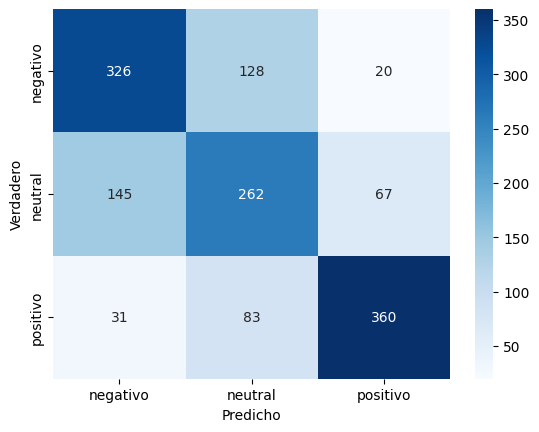

In [30]:
#Matriz de confusión para revisar las cantidades predichas mas visualmente y entender

cm = confusion_matrix(y_test, y_test_pred, labels=[0,1,2])  # 0=negativo,1=neutral,2=positivo
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negativo','neutral','positivo'],
            yticklabels=['negativo','neutral','positivo'])
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.show()

## **Conclusión**

El objetivo principal de este proyecto fue desarrollar un clasificador de sentimiento para reseñas de ropa femenina, categorizando cada reseña como negativa, neutral o positiva. Tras evaluar varios algoritmos, el modelo Multinomial Naive Bayes resultó el de mejor desempeño en nuestro conjunto equilibrado de aproximadamente 6000 reseñas, alcanzando un macro-F1 de 0,667.


Por lo visto en la matriz de confunsión, se puede analizar que el modelo identificó reseñas positivas con un 81 % de precisión y negativas con un 65 % de precisión, mientras que las neutrales se mantuvieron en 55 % de precisión. Aunque el clasificador maneja bien las polaridades claras, tiende a confundir comentarios de tono moderado o mixto y frases como “Estuvo bien” fueron un reto para el análisis de sentimiento.


Para abordar estas debilidades, en trabajos futuros se podria intentar aplicar otras técnicas de remuestreo focalizado, ajustes de pesos de clase para reforzar la categoría neutral, probar modelos mas robustos, o incluso no incluir reviews neutrales para directamente concentrar la predicción en si se inclina más a ser positiva o negativa.


Implementando estas mejoras y contando de mayor tiempo para refinar el modelo, el sistema no solo podría mejorar su capacidad para reconocer matices, sino tambien convertirse en una herramienta más sólida y confiable para traducir las voces de las clientes en acciones concretas.